In [4]:
import os
import cv2
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [5]:
DATA_DIR = '/media/obin/5d368da0-d601-490b-b5d8-6122946470b8/DATA/vistarget_demo2/train/medium'
data_list = [os.path.join(DATA_DIR,x) for x in os.listdir(DATA_DIR)]

# load Check

In [ ]:
splits = ['train', 'val']
for split in splits:
    DATA_DIR = '/media/obin/5d368da0-d601-490b-b5d8-6122946470b8/DATA/vistarget_demo2/{}/medium'.format(split)
    data_list = [os.path.join(DATA_DIR,x) for x in os.listdir(DATA_DIR)]
    for data_file in tqdm(data_list):
        try:
            data = joblib.load(data_file)
        except:
            print(data_file)

/media/obin/5d368da0-d601-490b-b5d8-6122946470b8/DATA/vistarget_demo2/train/medium/17DRP5sb8fy_305_env3.dat.gz



In [15]:
import time
from typing import Any, Dict, Iterator, List, Optional, Tuple, Type, Union

import gym
import numpy as np
from gym.spaces.dict_space import Dict as SpaceDict

from habitat.config import Config
from habitat.datasets import make_dataset
from habitat.sims import make_sim
from habitat.tasks import make_task
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "9"
from habitat_sim.utils.common import quat_to_coeffs
import quaternion as q
import habitat_sim
import habitat
from gym.spaces.dict_space import Dict as SpaceDict
from gym.spaces.box import Box
from tqdm import tqdm
import pickle

SPLIT = 'train'
if not os.path.exists(DATA_DIR): os.mkdir(DATA_DIR)
import joblib

MAX_DIST = np.Inf
MIN_DIST = 1.5

NEAR_DIST_TH = 1.5
MIDDLE_DIST_TH = 3.0

MEDIUM_MAX_FAR_DIST = 5.0

import numpy as np
def add_panoramic_camera(task_config):

    task_config.SIMULATOR.RGB_SENSOR_LEFT = task_config.SIMULATOR.RGB_SENSOR.clone()
    task_config.SIMULATOR.RGB_SENSOR_LEFT.TYPE = "PanoramicPartRGBSensor"
    task_config.SIMULATOR.RGB_SENSOR_LEFT.ORIENTATION = [0, 2/3 * np.pi, 0]
    task_config.SIMULATOR.RGB_SENSOR_LEFT.ANGLE = "left"
    task_config.SIMULATOR.RGB_SENSOR_RIGHT = task_config.SIMULATOR.RGB_SENSOR.clone()
    task_config.SIMULATOR.RGB_SENSOR_RIGHT.TYPE = "PanoramicPartRGBSensor"
    task_config.SIMULATOR.RGB_SENSOR_RIGHT.ORIENTATION = [0, -2/3 * np.pi, 0]
    task_config.SIMULATOR.RGB_SENSOR_RIGHT.ANGLE = "right"
    task_config.SIMULATOR.AGENT_0.SENSORS = ['RGB_SENSOR', 'RGB_SENSOR_LEFT', 'RGB_SENSOR_RIGHT']

    task_config.SIMULATOR.DEPTH_SENSOR_LEFT = task_config.SIMULATOR.DEPTH_SENSOR.clone()
    task_config.SIMULATOR.DEPTH_SENSOR_LEFT.TYPE = "PanoramicPartDepthSensor"
    task_config.SIMULATOR.DEPTH_SENSOR_LEFT.ORIENTATION = [0, 2/3 * np.pi, 0]
    task_config.SIMULATOR.DEPTH_SENSOR_LEFT.ANGLE = "left"
    task_config.SIMULATOR.DEPTH_SENSOR_RIGHT = task_config.SIMULATOR.DEPTH_SENSOR.clone()
    task_config.SIMULATOR.DEPTH_SENSOR_RIGHT.TYPE = "PanoramicPartDepthSensor"
    task_config.SIMULATOR.DEPTH_SENSOR_RIGHT.ORIENTATION = [0, -2/3 * np.pi, 0]
    task_config.SIMULATOR.DEPTH_SENSOR_RIGHT.ANGLE = "right"
    task_config.SIMULATOR.AGENT_0.SENSORS += ['DEPTH_SENSOR', 'DEPTH_SENSOR_LEFT', 'DEPTH_SENSOR_RIGHT']

    task_config.TASK.CUSTOM_VISTARGET_SENSOR = habitat.Config()
    task_config.TASK.CUSTOM_VISTARGET_SENSOR.TYPE = 'CustomVisTargetSensor'
    
    task_config.TASK.PANORAMIC_SENSOR = habitat.Config()
    task_config.TASK.PANORAMIC_SENSOR.TYPE = 'PanoramicRGBSensor'
    task_config.TASK.PANORAMIC_SENSOR.WIDTH = task_config.SIMULATOR.RGB_SENSOR.WIDTH
    task_config.TASK.PANORAMIC_SENSOR.HEIGHT = task_config.SIMULATOR.RGB_SENSOR.HEIGHT
    task_config.TASK.PANORAMIC_DEPTH_SENSOR = task_config.SIMULATOR.DEPTH_SENSOR.clone()
    task_config.TASK.PANORAMIC_DEPTH_SENSOR.TYPE = 'PanoramicDepthSensor'
    task_config.TASK.PANORAMIC_DEPTH_SENSOR.WIDTH = task_config.SIMULATOR.DEPTH_SENSOR.WIDTH
    task_config.TASK.PANORAMIC_DEPTH_SENSOR.HEIGHT = task_config.SIMULATOR.DEPTH_SENSOR.HEIGHT

    if "STOP" not in task_config.TASK.POSSIBLE_ACTIONS:
        task_config.TASK.SUCCESS.TYPE = "Success_woSTOP"
    task_config.TASK.SUCCESS.SUCCESS_DISTANCE = task_config.TASK.SUCCESS_DISTANCE

    return task_config


class DataCollectEnv:
    def __init__(
        self, config: Config
    ) -> None:
        """Constructor

        :param config: config for the environment. Should contain id for
            simulator and ``task_name`` which are passed into ``make_sim`` and
            ``make_task``.
        :param dataset: reference to dataset for task instance level
            information. Can be defined as :py:`None` in which case
            ``_episodes`` should be populated from outside.
        """

        assert config.is_frozen(), (
            "Freeze the config before creating the "
            "environment, use config.freeze()."
        )
        self._config = config
        self._current_episode_index = None
        self._current_episode = None
        self._scenes = config.DATASET.CONTENT_SCENES
        self._swap_building_every = config.ENVIRONMENT.ITERATOR_OPTIONS.MAX_SCENE_REPEAT_EPISODES
        self._current_scene_episode_idx = 0
        self._current_scene_idx = 0

        self._config.defrost()
        self._config.SIMULATOR.SCENE = os.path.join(config.DATASET.SCENES_DIR, 'mp3d/{}/{}.glb'.format(self._scenes,self._scenes))
        self._config.freeze()

        self._sim = make_sim(
            id_sim=self._config.SIMULATOR.TYPE, config=self._config.SIMULATOR
        )


    def validate_data(self, data):
        data_len = len(data['rgb'])
        for i in range(data_len):
            position = data['position'][i]
            rotation = q.from_float_array(data['rotation'][i])
            obs = self._sim.get_observations_at(position,rotation)
            new_rgb, new_depth = self.process_obs(obs)
            old_rgb, old_depth = data['rgb'][i], data['depth'][i]
            cv2.imshow('hi', np.concatenate([old_rgb, new_rgb],1))
            cv2.waitKey(0)
        return data
    
    def process_obs(self, obs):
        rgb = np.concatenate([obs['rgb_left'],obs['rgb'],obs['rgb_right']],1)
        depth = np.concatenate([obs['depth_left'],obs['depth'],obs['depth_right']],1)
        return rgb, depth

def collect_data(config): # 1 env per 1 config
    #np.random.seed(config.SEED)
    scene_name = config.DATASET.CONTENT_SCENES
    env = DataCollectEnv(config)
    scene_data_list = [x for x in data_list if scene_name in x]
    for data_file in tqdm(scene_data_list):
        data = joblib.load(data_file)
        new_data = env.validate_data(data)

    env._sim.close()

    return

In [17]:
splits = ['val', 'test','train']

from ..default import get_config
import numpy as np
from multiprocessing import Pool
import cv2
from env_utils.vistarget_nav_task import CustomVisTargetSensor

for split in splits:
    config = get_config('base.yaml')
    configs = []
    habitat_api_path = os.path.join(os.path.dirname(habitat.__file__), '../')
    config.defrost()
    config.TASK_CONFIG.DATASET.SCENES_DIR = os.path.join(habitat_api_path, config.TASK_CONFIG.DATASET.SCENES_DIR)
    config.TASK_CONFIG.DATASET.DATA_PATH = os.path.join(habitat_api_path, config.TASK_CONFIG.DATASET.DATA_PATH)
    config.TASK_CONFIG.DATASET.SPLIT = split
    config.freeze()

    dataset = make_dataset('PointNav-v1')
    scenes = config.TASK_CONFIG.DATASET.CONTENT_SCENES
    if "*" in config.TASK_CONFIG.DATASET.CONTENT_SCENES:
        scenes = dataset.get_scenes_to_load(config.TASK_CONFIG.DATASET)

    for i in range(len(scenes)):
        proc_config = config.clone()
        proc_config.defrost()

        task_config = proc_config.TASK_CONFIG
        task_config.DATASET.CONTENT_SCENES = scenes[i]

        task_config = add_panoramic_camera(task_config)

        task_config.SIMULATOR.HABITAT_SIM_V0.GPU_DEVICE_ID = (
            config.SIMULATOR_GPU_ID
        )

        proc_config.freeze()
        configs.append(proc_config.TASK_CONFIG)
    collect_data(configs[0])
    break

    # process map configs
    #num_thread = 7
    #start = time.time()
    #with Pool(num_thread) as p:
        #p.map(collect_data, configs, int(len(configs) / num_thread))
    #end = time.time() - start

ValueError: attempted relative import beyond top-level package

In [18]:
for data_file in data_list:
    data = joblib.load(data_file)
    rgbs = data['rgb']
    pointer = 0
    p = False
    while pointer < len(rgbs):
        cv2.imshow('view',rgbs[pointer][:,:,[2,1,0]])
        key = cv2.waitKey(0)
        if key == ord('a'): pointer -= 1
        elif key == ord('d'): pointer += 1
        elif key == ord('p'): 
            break
        elif key == ord('q'):
            p = True
            break
        pointer = max(pointer, 0)
    if p is True : break

[12.017693    0.09863305 -4.450484  ] [-0.12792109  0.         -0.99178439  0.        ]


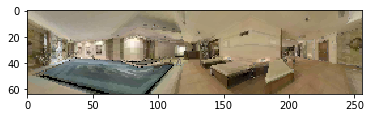

[12.017693    0.09863305 -4.450484  ] [-0.04099461  0.         -0.99915934  0.        ]


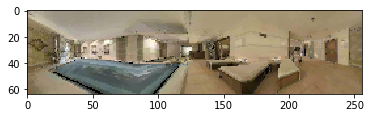

[12.017693    0.09863305 -4.450484  ] [ 0.04624385  0.         -0.99893022  0.        ]


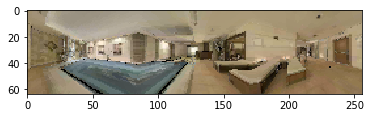

[12.017693    0.09863305 -4.450484  ] [ 0.13313039  0.         -0.99109858  0.        ]


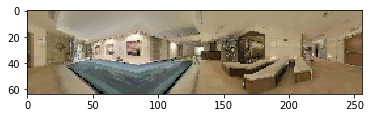

[12.083665    0.09863305 -4.209346  ] [ 0.13313039  0.         -0.99109858  0.        ]


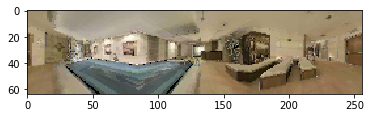

[12.149637    0.09863305 -3.9682076 ] [ 0.13313039  0.         -0.99109858  0.        ]


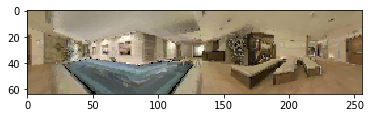

[12.21561     0.09863305 -3.7270694 ] [ 0.13313039  0.         -0.99109858  0.        ]


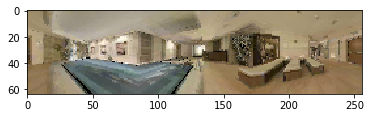

[12.21561     0.09863305 -3.7270694 ] [ 0.21900372  0.         -0.9757241   0.        ]


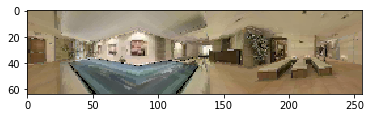

[12.3224535   0.09863305 -3.5010507 ] [ 0.21900372  0.         -0.9757241   0.        ]


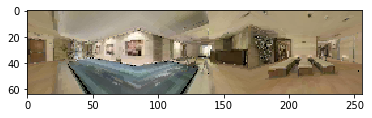

[12.429297    0.09863305 -3.275032  ] [ 0.21900372  0.         -0.9757241   0.        ]


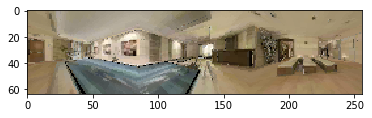

[12.429297    0.09863305 -3.275032  ] [ 0.30321026  0.         -0.95292366  0.        ]


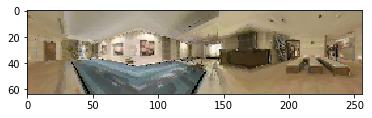

[12.573766    0.09863305 -3.0710003 ] [ 0.30321026  0.         -0.95292366  0.        ]


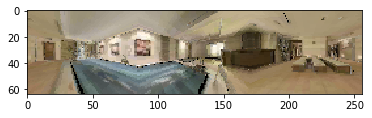

[12.573766    0.09863305 -3.0710003 ] [ 0.38510922  0.         -0.92287099  0.        ]


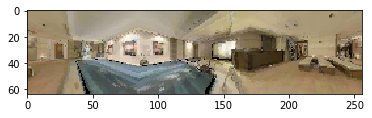

[12.751469    0.09863305 -2.895155  ] [ 0.38510922  0.         -0.92287099  0.        ]


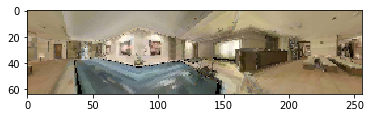

[12.751469    0.09863305 -2.895155  ] [ 0.46407729  0.         -0.88579476  0.        ]


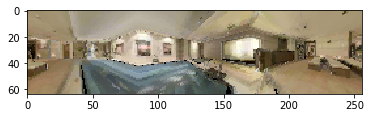

[12.957007    0.09863305 -2.7528389 ] [ 0.46407729  0.         -0.88579476  0.        ]


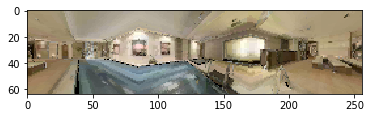

[13.162546    0.09863305 -2.6105227 ] [ 0.46407729  0.         -0.88579476  0.        ]


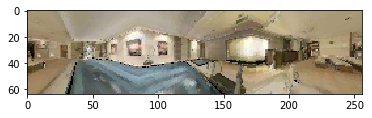

[13.368085    0.09863305 -2.4682066 ] [ 0.46407729  0.         -0.88579476  0.        ]


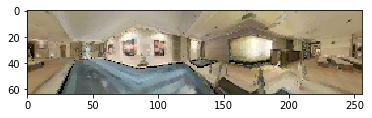

[13.368085    0.09863305 -2.4682066 ] [ 0.53951347  0.         -0.84197706  0.        ]


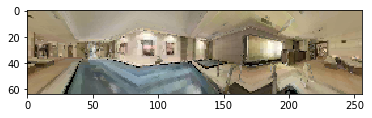

[13.595214    0.09863305 -2.363744  ] [ 0.53951347  0.         -0.84197706  0.        ]


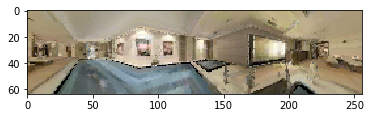

[13.822343    0.09863305 -2.2592814 ] [ 0.53951347  0.         -0.84197706  0.        ]


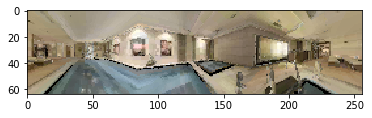

[13.822343    0.09863305 -2.2592814 ] [ 0.61084354  0.         -0.79175133  0.        ]


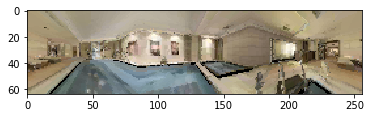

[14.064161    0.09863305 -2.1958463 ] [ 0.61084354  0.         -0.79175133  0.        ]


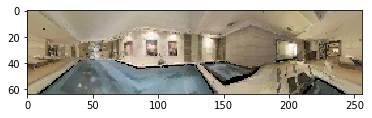

[14.064161    0.09863305 -2.1958463 ] [ 0.67752481  0.         -0.73549998  0.        ]


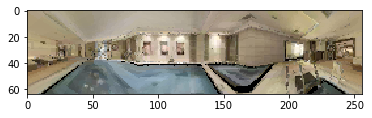

[14.064161    0.09863305 -2.1958463 ] [ 0.73904967  0.         -0.67365098  0.        ]


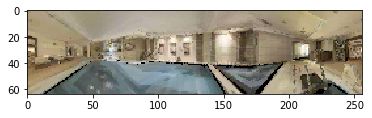

[14.064161    0.09863305 -2.1958463 ] [ 0.79494983  0.         -0.60667509  0.        ]


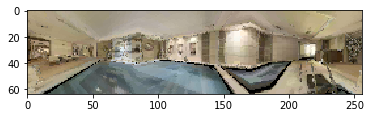

[14.064161    0.09863305 -2.1958463 ] [ 0.84480006  0.         -0.5350821   0.        ]


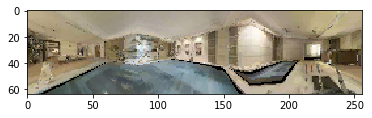

[14.064161    0.09863305 -2.1958463 ] [ 0.88822085  0.         -0.45941681  0.        ]


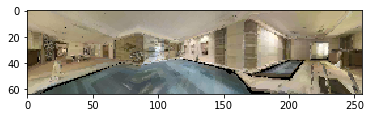

[14.064161    0.09863305 -2.1958463 ] [ 0.9248817   0.         -0.38025504  0.        ]


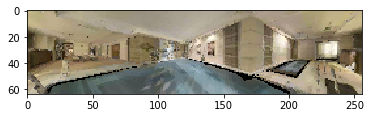

[14.064161    0.09863305 -2.1958463 ] [ 0.95450372  0.         -0.29819933  0.        ]


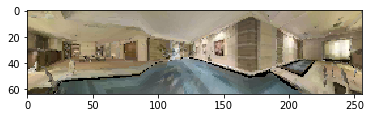

[14.064161    0.09863305 -2.1958463 ] [ 0.97686124  0.         -0.2138741   0.        ]


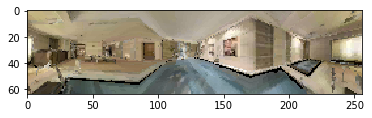

[14.064161    0.09863305 -2.1958463 ] [ 0.99178433  0.         -0.12792119  0.        ]


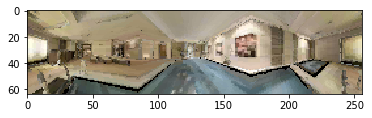

[14.064161    0.09863305 -2.1958463 ] [ 0.9991594   0.         -0.04099473  0.        ]


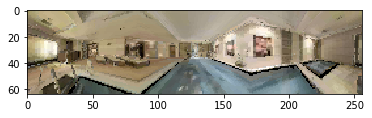

[14.064161    0.09863305 -2.1958463 ] [0.99893028 0.         0.04624375 0.        ]


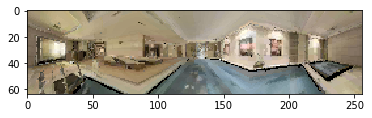

[14.064161    0.09863305 -2.1958463 ] [0.99109864 0.         0.13313028 0.        ]


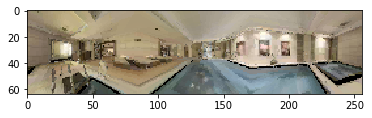

[14.064161    0.09863305 -2.1958463 ] [0.97572404 0.         0.21900359 0.        ]


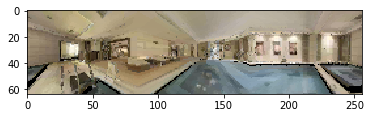

[14.064161    0.09863305 -2.1958463 ] [0.95292372 0.         0.30321017 0.        ]


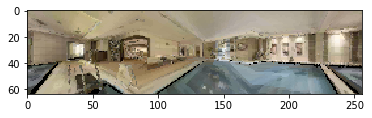

[14.064161    0.09863305 -2.1958463 ] [0.92287105 0.         0.38510913 0.        ]


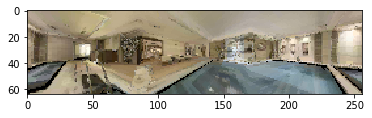

[13.886458    0.09863305 -2.3716917 ] [0.92287105 0.         0.38510913 0.        ]


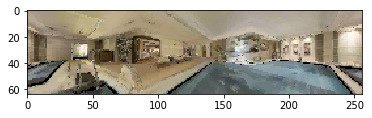

[13.886458    0.09863305 -2.3716917 ] [0.88579482 0.         0.4640772  0.        ]


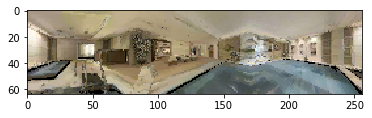

[13.68092     0.09863305 -2.5140078 ] [0.88579482 0.         0.4640772  0.        ]


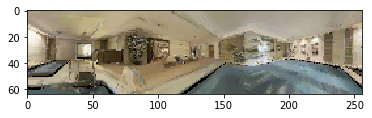

[13.475381    0.09863305 -2.656324  ] [0.88579482 0.         0.4640772  0.        ]


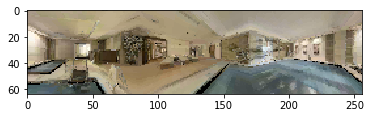

[13.475381    0.09863305 -2.656324  ] [0.84197712 0.         0.53951335 0.        ]


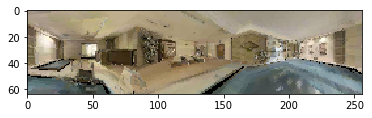

[13.248252    0.09863305 -2.7607865 ] [0.84197712 0.         0.53951335 0.        ]


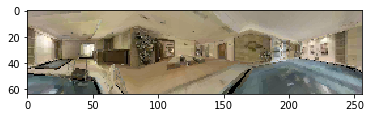

[13.021123    0.09863305 -2.8652492 ] [0.84197712 0.         0.53951335 0.        ]


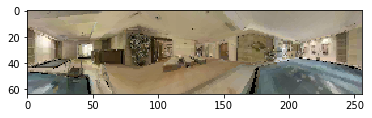

[12.768383    0.09863305 -2.9376984 ] [0.84197712 0.         0.53951335 0.        ]


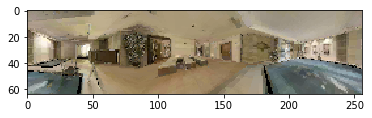

[12.768383    0.09863305 -2.9376984 ] [0.88579482 0.         0.46407717 0.        ]


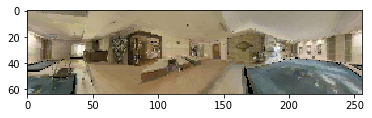

[12.562844    0.09863305 -3.0800145 ] [0.88579482 0.         0.46407717 0.        ]


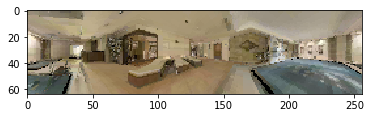

[12.562844    0.09863305 -3.0800145 ] [0.92287111 0.         0.38510913 0.        ]


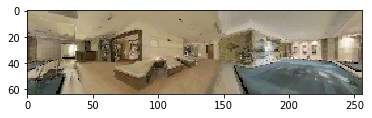

[12.385141    0.09863305 -3.2558599 ] [0.92287111 0.         0.38510913 0.        ]


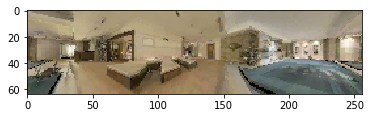

[12.207438    0.09863305 -3.4317052 ] [0.92287111 0.         0.38510913 0.        ]


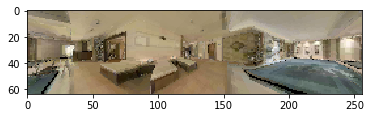

[12.029736    0.09863305 -3.6075506 ] [0.92287111 0.         0.38510913 0.        ]


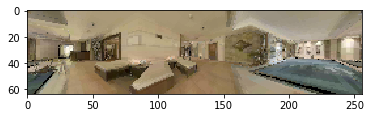

[12.029736    0.09863305 -3.6075506 ] [0.95292377 0.         0.30321017 0.        ]


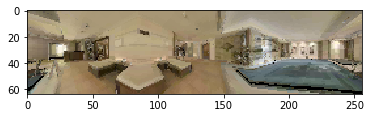

[12.029736    0.09863305 -3.6075506 ] [0.9757241  0.         0.21900359 0.        ]


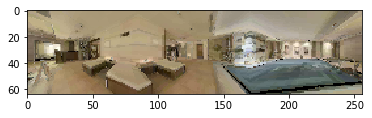

[12.029736    0.09863305 -3.6075506 ] [0.99109864 0.         0.13313025 0.        ]


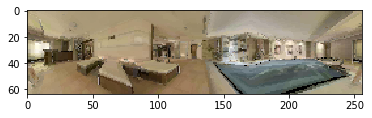

[12.029736    0.09863305 -3.6075506 ] [0.99893028 0.         0.04624373 0.        ]


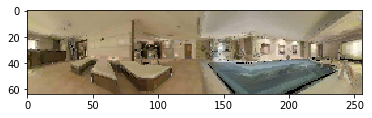

[12.029736    0.09863305 -3.6075506 ] [ 0.99915934  0.         -0.04099475  0.        ]


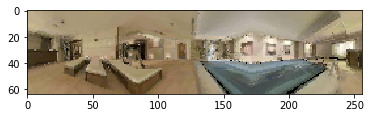

[12.050216    0.09863305 -3.8567104 ] [ 0.99915934  0.         -0.04099475  0.        ]


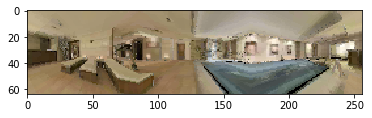

[12.050216    0.09863305 -3.8567104 ] [ 0.99178433  0.         -0.12792122  0.        ]


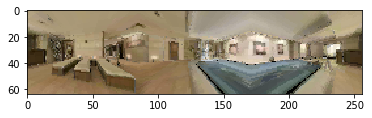

[12.113651    0.09863305 -4.0985284 ] [ 0.99178433  0.         -0.12792122  0.        ]


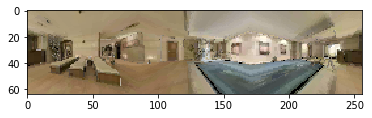

[12.177087    0.09863305 -4.3403463 ] [ 0.99178433  0.         -0.12792122  0.        ]


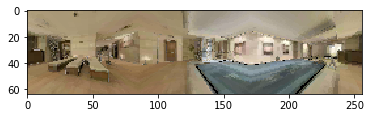

[12.240522    0.09863305 -4.5821643 ] [ 0.99178433  0.         -0.12792122  0.        ]


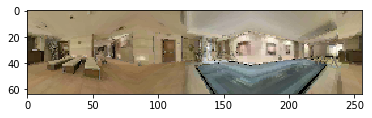

[12.303958    0.09863305 -4.8239822 ] [ 0.99178433  0.         -0.12792122  0.        ]


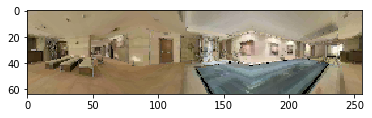

[12.303958    0.09863305 -4.8239822 ] [ 0.9768613   0.         -0.21387413  0.        ]


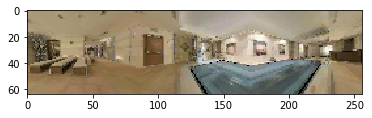

[12.408421    0.09863305 -5.051111  ] [ 0.9768613   0.         -0.21387413  0.        ]


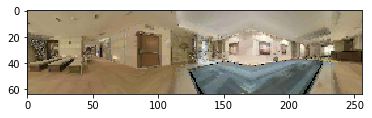

[12.408421    0.09863305 -5.051111  ] [ 0.9545036   0.         -0.29819933  0.        ]


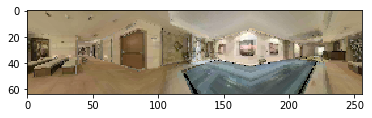

[12.550736    0.09863305 -5.25665   ] [ 0.9545036   0.         -0.29819933  0.        ]


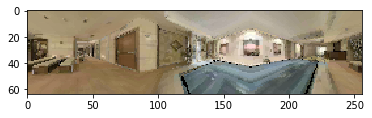

[12.550736    0.09863305 -5.25665   ] [ 0.9248817   0.         -0.38025507  0.        ]


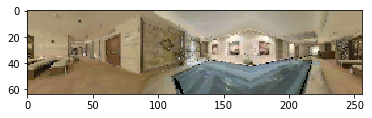

[12.550736    0.09863305 -5.25665   ] [ 0.88822085  0.         -0.45941687  0.        ]


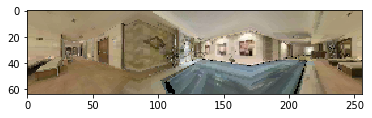

[12.754768    0.09863305 -5.4011183 ] [ 0.88822085  0.         -0.45941687  0.        ]


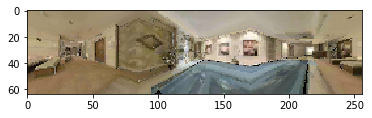

[12.754768    0.09863305 -5.4011183 ] [ 0.8448      0.         -0.53508216  0.        ]


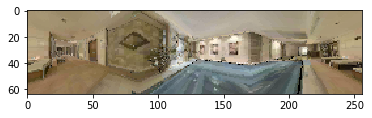

[12.980787    0.09863305 -5.5079618 ] [ 0.8448      0.         -0.53508216  0.        ]


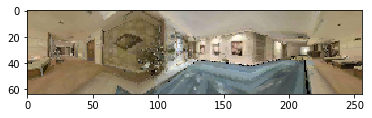

[13.206806    0.09863305 -5.614805  ] [ 0.8448      0.         -0.53508216  0.        ]


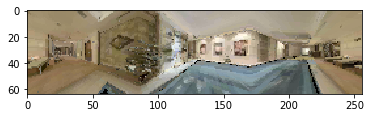

[13.432825    0.09863305 -5.7216487 ] [ 0.8448      0.         -0.53508216  0.        ]


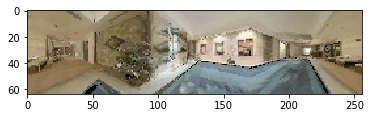

[13.658844    0.09863305 -5.828492  ] [ 0.8448      0.         -0.53508216  0.        ]


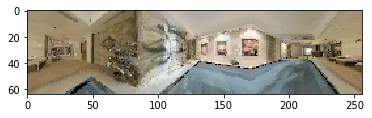

[13.658844    0.09863305 -5.828492  ] [ 0.79494983  0.         -0.60667521  0.        ]


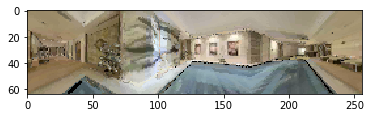

[13.899982    0.09863305 -5.894465  ] [ 0.79494983  0.         -0.60667521  0.        ]


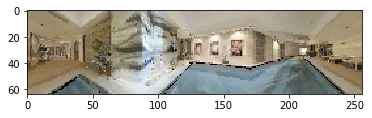

[14.141121    0.09863305 -5.960438  ] [ 0.79494983  0.         -0.60667521  0.        ]


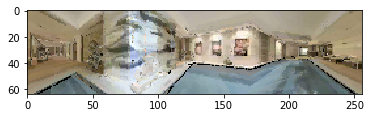

[14.382259    0.09863305 -6.0264106 ] [ 0.79494983  0.         -0.60667521  0.        ]


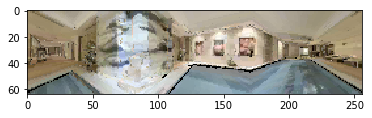

[14.382259    0.09863305 -6.0264106 ] [ 0.73904961  0.         -0.6736511   0.        ]


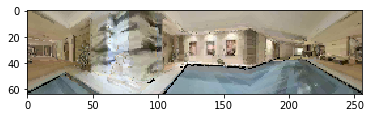

[14.63119     0.09863305 -6.0495076 ] [ 0.73904961  0.         -0.6736511   0.        ]


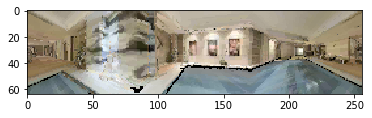

[14.63119     0.09863305 -6.0495076 ] [ 0.79494977  0.         -0.60667521  0.        ]


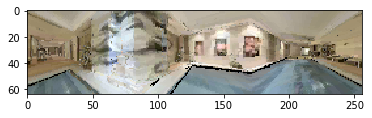

[14.63119     0.09863305 -6.0495076 ] [ 0.8448      0.         -0.53508222  0.        ]


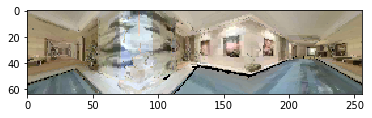

[14.63119     0.09863305 -6.0495076 ] [ 0.88822079  0.         -0.4594169   0.        ]


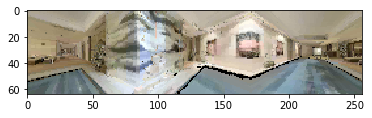

[14.63119     0.09863305 -6.0495076 ] [ 0.92488164  0.         -0.38025516  0.        ]


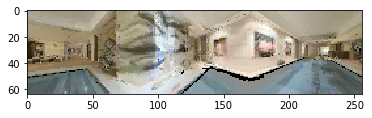

[14.63119     0.09863305 -6.0495076 ] [ 0.95450366  0.         -0.29819942  0.        ]


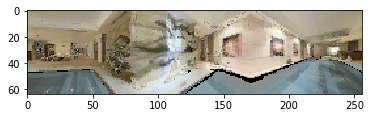

[14.63119     0.09863305 -6.0495076 ] [ 0.97686118  0.         -0.21387419  0.        ]


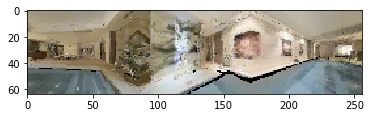

[14.63119     0.09863305 -6.0495076 ] [ 0.99178433  0.         -0.1279213   0.        ]


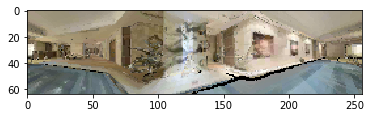

[14.63119     0.09863305 -6.0495076 ] [ 0.9991594   0.         -0.04099483  0.        ]


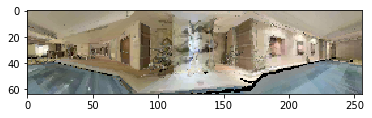

[14.63119     0.09863305 -6.0495076 ] [0.99893028 0.         0.04624364 0.        ]


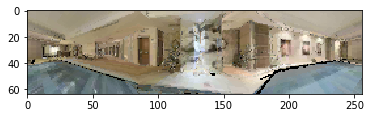

[14.63119     0.09863305 -6.0495076 ] [0.99109864 0.         0.13313018 0.        ]


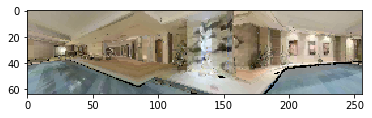

[14.63119     0.09863305 -6.0495076 ] [0.97572416 0.         0.21900351 0.        ]


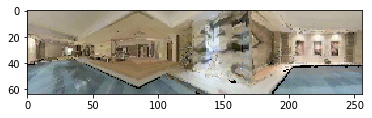

[14.63119     0.09863305 -6.0495076 ] [0.95292372 0.         0.30321008 0.        ]


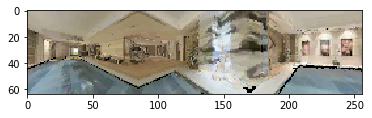

[14.63119     0.09863305 -6.0495076 ] [0.92287105 0.         0.38510907 0.        ]


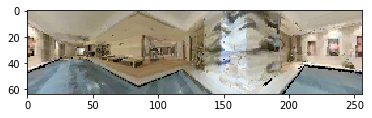

[14.63119     0.09863305 -6.0495076 ] [0.88579482 0.         0.46407714 0.        ]


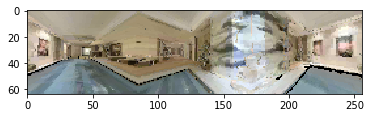

[14.63119     0.09863305 -6.0495076 ] [0.84197712 0.         0.53951329 0.        ]


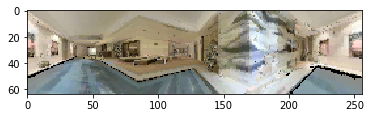

[14.63119     0.09863305 -6.0495076 ] [0.79175144 0.         0.61084342 0.        ]


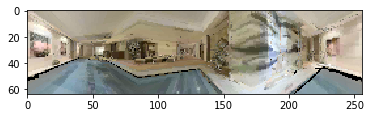

[14.63119     0.09863305 -6.0495076 ] [0.7355001  0.         0.67752469 0.        ]


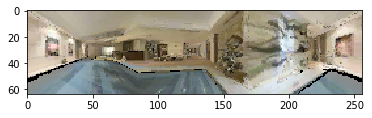

[14.3820305   0.09863305 -6.069988  ] [0.7355001  0.         0.67752469 0.        ]


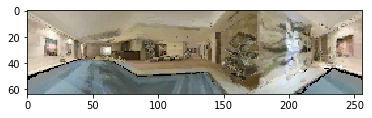

[14.132871    0.09863305 -6.090468  ] [0.7355001  0.         0.67752469 0.        ]


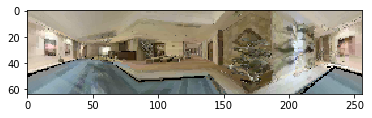

[13.883711    0.09863305 -6.110948  ] [0.7355001  0.         0.67752469 0.        ]


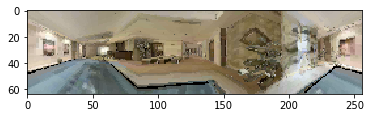

[13.883711    0.09863305 -6.110948  ] [0.67365116 0.         0.73904955 0.        ]


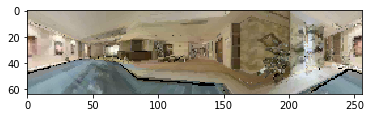

[13.63478     0.09863305 -6.087851  ] [0.67365116 0.         0.73904955 0.        ]


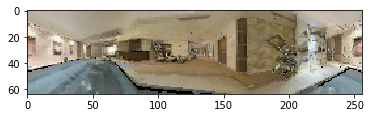

[13.385849    0.09863305 -6.064754  ] [0.67365116 0.         0.73904955 0.        ]


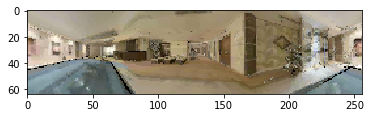

[13.385849    0.09863305 -6.064754  ] [0.60667527 0.         0.79494971 0.        ]


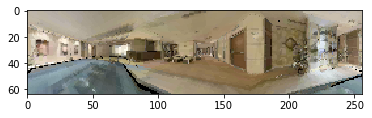

[13.144711    0.09863305 -5.9987817 ] [0.60667527 0.         0.79494971 0.        ]


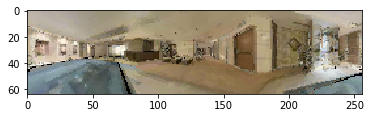

[12.929732    0.09863305 -5.8935685 ] [0.60667527 0.         0.79494971 0.        ]


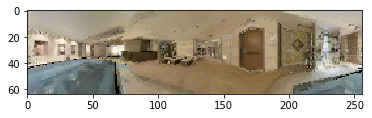

[12.929732    0.09863305 -5.8935685 ] [0.53508228 0.         0.84479994 0.        ]


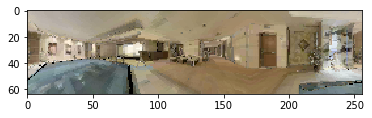

[12.703713    0.09863305 -5.786725  ] [0.53508228 0.         0.84479994 0.        ]


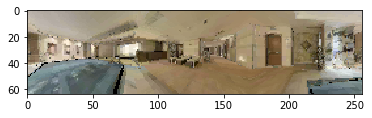

[12.703713    0.09863305 -5.786725  ] [0.60667533 0.         0.79494977 0.        ]


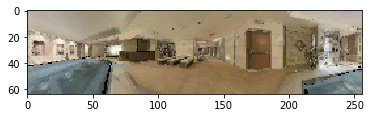

[12.703713    0.09863305 -5.786725  ] [0.67365116 0.         0.73904949 0.        ]


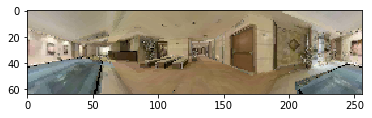

[12.703713    0.09863305 -5.786725  ] [0.7355001  0.         0.67752463 0.        ]


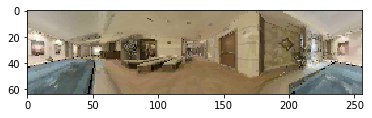

[12.703713    0.09863305 -5.786725  ] [0.7917515  0.         0.61084342 0.        ]


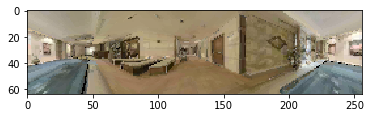

[12.703713    0.09863305 -5.786725  ] [0.84197706 0.         0.53951329 0.        ]


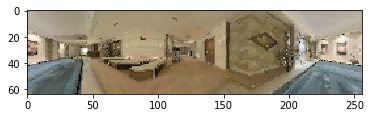

[12.703713    0.09863305 -5.786725  ] [0.88579482 0.         0.46407714 0.        ]


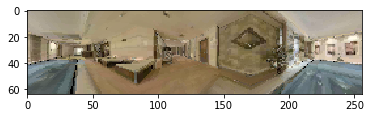

[12.703713    0.09863305 -5.786725  ] [0.92287111 0.         0.38510913 0.        ]


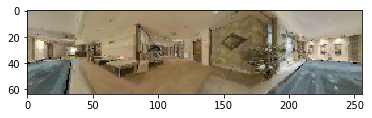

[12.703713    0.09863305 -5.786725  ] [0.95292377 0.         0.30321017 0.        ]


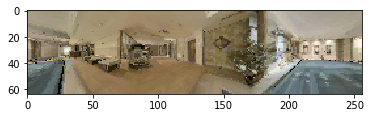

[12.703713    0.09863305 -5.786725  ] [0.9757241  0.         0.21900359 0.        ]


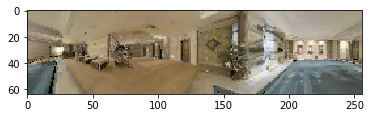

[12.596869    0.09863305 -6.012744  ] [0.9757241  0.         0.21900359 0.        ]


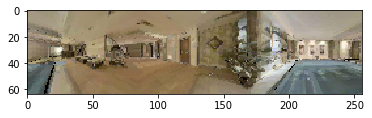

[12.596869    0.09863305 -6.012744  ] [0.99109864 0.         0.13313025 0.        ]


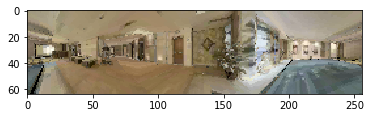

[12.596869    0.09863305 -6.012744  ] [0.99893028 0.         0.04624373 0.        ]


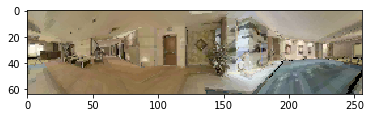

[12.573772    0.09863305 -6.261675  ] [0.99893028 0.         0.04624373 0.        ]


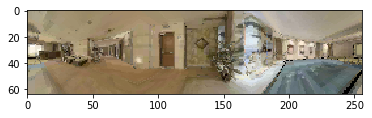

[12.550675    0.09863305 -6.510606  ] [0.99893028 0.         0.04624373 0.        ]


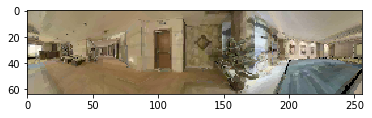

[12.550675    0.09863305 -6.510606  ] [ 0.99915934  0.         -0.04099475  0.        ]


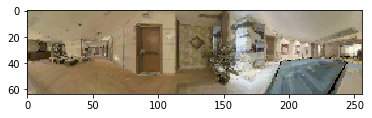

[12.571156    0.09863305 -6.7597656 ] [ 0.99915934  0.         -0.04099475  0.        ]


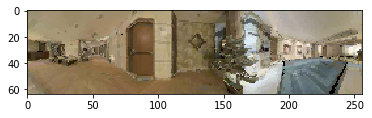

[12.591636    0.09863305 -7.0089254 ] [ 0.99915934  0.         -0.04099475  0.        ]


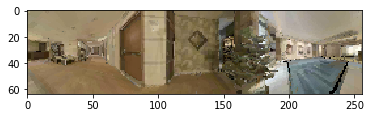

[12.612116    0.09863305 -7.2580853 ] [ 0.99915934  0.         -0.04099475  0.        ]


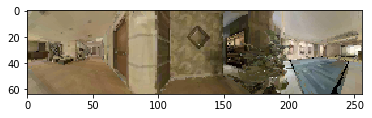

[12.632596    0.09863305 -7.507245  ] [ 0.99915934  0.         -0.04099475  0.        ]


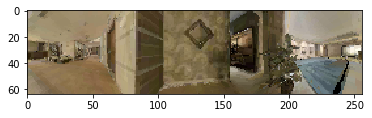

[12.632596    0.09863305 -7.507245  ] [ 0.99178433  0.         -0.12792122  0.        ]


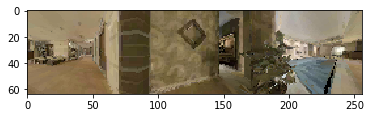

[12.696032    0.09863305 -7.749063  ] [ 0.99178433  0.         -0.12792122  0.        ]


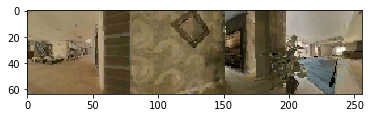

[12.696032    0.09863305 -7.749063  ] [ 0.9768613   0.         -0.21387413  0.        ]


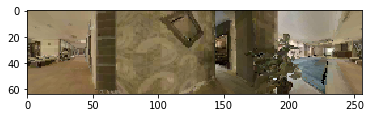

[12.696032    0.09863305 -7.749063  ] [ 0.9545036   0.         -0.29819933  0.        ]


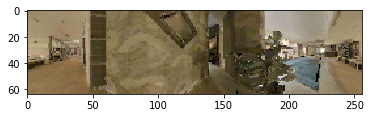

[12.696032    0.09863305 -7.749063  ] [ 0.9248817   0.         -0.38025507  0.        ]


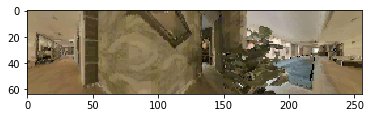

[12.696032    0.09863305 -7.749063  ] [ 0.88822085  0.         -0.45941687  0.        ]


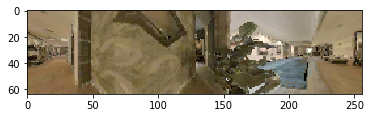

[12.696032    0.09863305 -7.749063  ] [ 0.8448      0.         -0.53508216  0.        ]


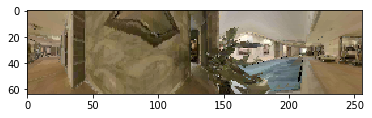

[12.696032    0.09863305 -7.749063  ] [ 0.79494983  0.         -0.60667521  0.        ]


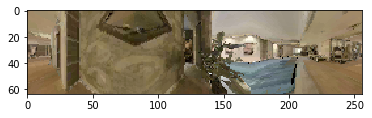

[12.696032    0.09863305 -7.749063  ] [ 0.73904961  0.         -0.6736511   0.        ]


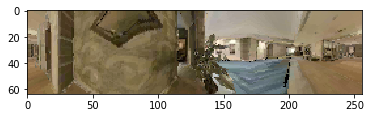

[12.696032    0.09863305 -7.749063  ] [ 0.67752475  0.         -0.73550004  0.        ]


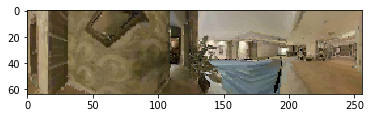

[12.696032    0.09863305 -7.749063  ] [ 0.61084348  0.         -0.79175138  0.        ]


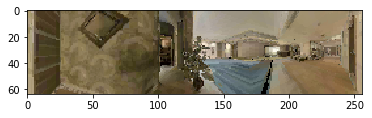

[12.696032    0.09863305 -7.749063  ] [ 0.53951341  0.         -0.84197706  0.        ]


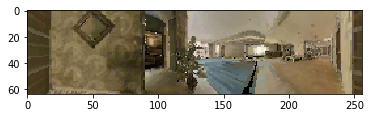

[12.696032    0.09863305 -7.749063  ] [ 0.46407726  0.         -0.88579482  0.        ]


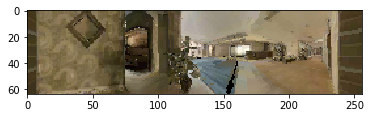

[12.696032    0.09863305 -7.749063  ] [ 0.38510919  0.         -0.92287099  0.        ]


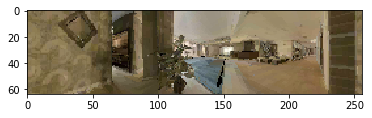

[12.696032    0.09863305 -7.749063  ] [ 0.30321029  0.         -0.95292372  0.        ]


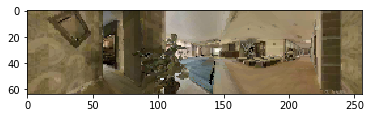

[12.696032    0.09863305 -7.749063  ] [ 0.21900372  0.         -0.97572404  0.        ]


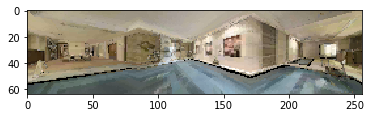

[12.696032    0.09863305 -7.749063  ] [ 0.1331304   0.         -0.99109858  0.        ]


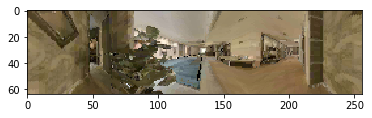

[12.696032    0.09863305 -7.749063  ] [ 0.04624388  0.         -0.99893022  0.        ]


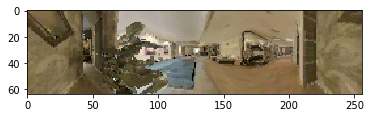

[12.719129    0.09863305 -7.500132  ] [ 0.04624388  0.         -0.99893022  0.        ]


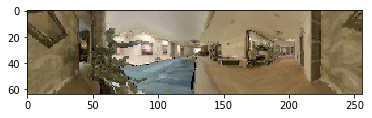

[12.742226    0.09863305 -7.251201  ] [ 0.04624388  0.         -0.99893022  0.        ]


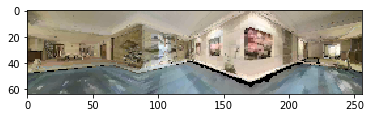

[12.742226    0.09863305 -7.251201  ] [-0.0409946  0.        -0.9991594  0.       ]


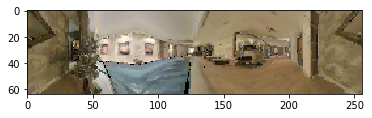

[12.7217455   0.09863305 -7.0020413 ] [-0.0409946  0.        -0.9991594  0.       ]


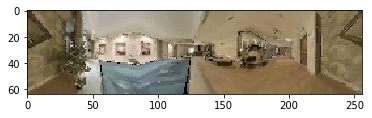

[12.701265    0.09863305 -6.7528815 ] [-0.0409946  0.        -0.9991594  0.       ]


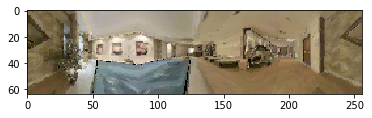

[12.621813    0.09863305 -6.5037217 ] [-0.0409946  0.        -0.9991594  0.       ]


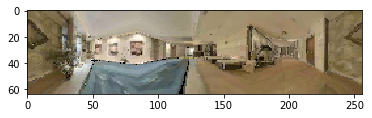

[12.601333    0.09863305 -6.254562  ] [-0.0409946  0.        -0.9991594  0.       ]


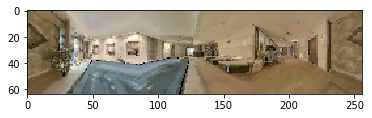

[12.601333    0.09863305 -6.254562  ] [ 0.04624387  0.         -0.99893016  0.        ]


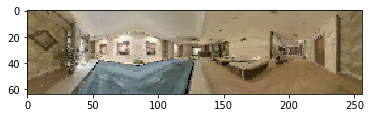

[12.62443     0.09863305 -6.005631  ] [ 0.04624387  0.         -0.99893016  0.        ]


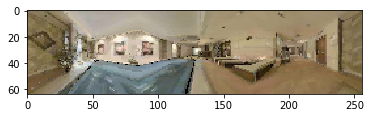

[12.62443     0.09863305 -6.005631  ] [ 0.13313042  0.         -0.99109858  0.        ]


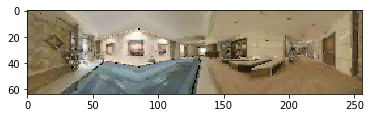

[12.62443     0.09863305 -6.005631  ] [ 0.21900375  0.         -0.9757241   0.        ]


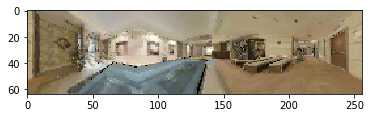

[12.62443     0.09863305 -6.005631  ] [ 0.30321029  0.         -0.95292366  0.        ]


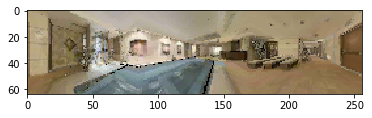

[12.62443     0.09863305 -6.005631  ] [ 0.38510925  0.         -0.92287099  0.        ]


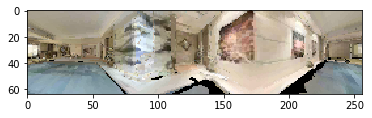

[12.802133    0.09863305 -5.8297853 ] [ 0.38510925  0.         -0.92287099  0.        ]


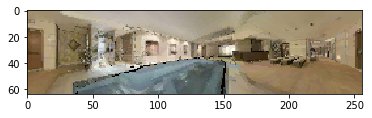

[12.9798355   0.09863305 -5.6539397 ] [ 0.38510925  0.         -0.92287099  0.        ]


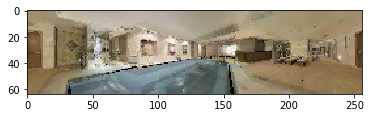

[13.157538    0.09863305 -5.478094  ] [ 0.38510925  0.         -0.92287099  0.        ]


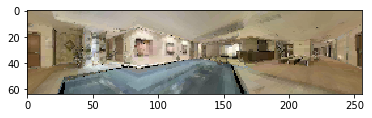

[13.335241    0.09863305 -5.3022485 ] [ 0.38510925  0.         -0.92287099  0.        ]


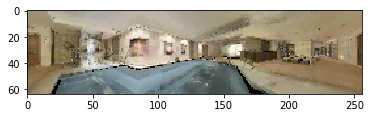

In [11]:
for i, rgb in enumerate(rgbs):
    print(data['position'][i],data['rotation'][i])
    plt.imshow(rgb)
    plt.show()
